In [103]:
import re
import numpy as np
import random
import spacy
import pandas as pd
from textblob import TextBlob
from spacy import displacy
from collections import Counter
import en_core_web_md
nlp = en_core_web_md.load()

import warnings
warnings.filterwarnings('ignore')

In [77]:
eng_tweets = pd.read_pickle('../data/eng_tweets.p')

In [78]:
eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub(r'"''~',"",str(x)))

In [80]:
eng_tweets.content.head()

0    We have a sitting Democrat US Senator on trial...
1    Marshawn Lynch arrives to game in anti Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN President Trump dedicates Presidents C...
4    19000 RESPECTING our National Anthem Stand For...
Name: content, dtype: object

In [81]:
targets = ['RightTroll', 'LeftTroll', 'Newsfeed']
eng_tweets = eng_tweets.loc[eng_tweets.account_category.isin(targets)]

In [79]:
eng_tweets.shape

(1906516, 18)

In [85]:
subset = eng_tweets.loc[0:10000]

In [86]:
#entities = []
#labels = []
#sentences = []
#for tweet in subset.content:
#    doc = nlp(tweet)
#    entities.append([ent.text for ent in doc.ents])
#    labels.append([ent.label_ for ent in doc.ents])
#    sentences.append([sent for sent in doc.sents])

In [87]:
subset['docs'] = subset.content.apply(nlp)

In [88]:
subset['entities'] = subset.docs.apply(lambda doc: [ent.text for ent in doc.ents])

In [89]:
subset['labels'] = subset.docs.apply(lambda doc: [ent.label_ for ent in doc.ents])

In [90]:
subset['sentences'] = subset.docs.apply(lambda doc: [sent for sent in doc.sents])

In [91]:
flattened_entities = subset.entities.tolist()
flattened_entities = pd.Series([str(item) for sublist in flattened_entities for item in sublist])

flattened_labels = subset.labels.tolist()
flattened_labels = pd.Series([str(item) for sublist in flattened_labels for item in sublist])

In [92]:
flattened_entities.loc[0:10]

0           Democrat
1                 US
2     Marshawn Lynch
3              Trump
4              Lynch
5               Navy
6                NFL
7        Boycott NFL
8              Trump
9            Florida
10             Texas
dtype: object

In [93]:
flattened_labels.loc[0:10]

0       NORP
1        GPE
2     PERSON
3        ORG
4        ORG
5        ORG
6        ORG
7        ORG
8     PERSON
9        GPE
10       GPE
dtype: object

In [99]:
top20 = Counter(flattened_entities).most_common(20)
top20

[('Black Lives Matter', 229),
 ('Black Twitter', 128),
 ('America', 83),
 ('Black Lives', 81),
 ('4mysquad', 81),
 ('Shaun King', 69),
 ('BLM', 68),
 ('Donald Trump', 67),
 ('4', 61),
 ('US', 55),
 ('Reverant Revan', 55),
 ('2', 54),
 ('Trump', 45),
 ('one', 39),
 ('Fox News', 35),
 ('today', 33),
 ('CNN', 30),
 ('ABC', 29),
 ('NYPD', 28),
 ('Chicago', 26)]

In [158]:
people = flattened_entities.loc[flattened_labels=='PERSON']
top20people = Counter(people).most_common(20)
top20people = [x[0] for x in top20people]
top20people

['Black Twitter',
 'Shaun King',
 'Donald Trump',
 'Reverant Revan',
 'Hillary',
 'Trump',
 'Bernie Sanders',
 'Imma',
 'Hillary Clinton',
 'Tamir Rice',
 'Blkhysteria',
 'Fritz Colburn',
 'Laquan Mc Donald',
 'Snoop Dogg',
 'hogrider30',
 'Ferguson',
 'Malcolm X',
 'Black Fam',
 'Sandra Bland',
 'Joe Spectr']

In [159]:
org = flattened_entities.loc[flattened_labels=='ORG']
top20org = Counter(org).most_common(20)
top20org = [x[0] for x in top20org]
top20org

['BLM',
 'Fox News',
 'CNN',
 'ABC',
 'NYPD',
 'Trump',
 'ACAB',
 'ISIS',
 'Black Lives Matter',
 'POTUS',
 'Justice',
 'NRA',
 'MSNBC',
 'GOP',
 'NFL',
 'Obama',
 'KKK',
 'Reuters',
 'Brutality',
 'Islam']

In [160]:
for i in range(20):
    displacy.render(nlp(str(subset.sentences.loc[i])), jupyter=True, style='ent')

In [161]:
subset['sentiment'] = subset.content.astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

In [162]:
def get_polarity(sentiment):
    if sentiment > 0.0:
        return 'Positive'
    if sentiment < 0.0:
        return 'Negative'
    else:
        return 'Neutral'
subset['polarity'] = subset.sentiment.apply(get_polarity)

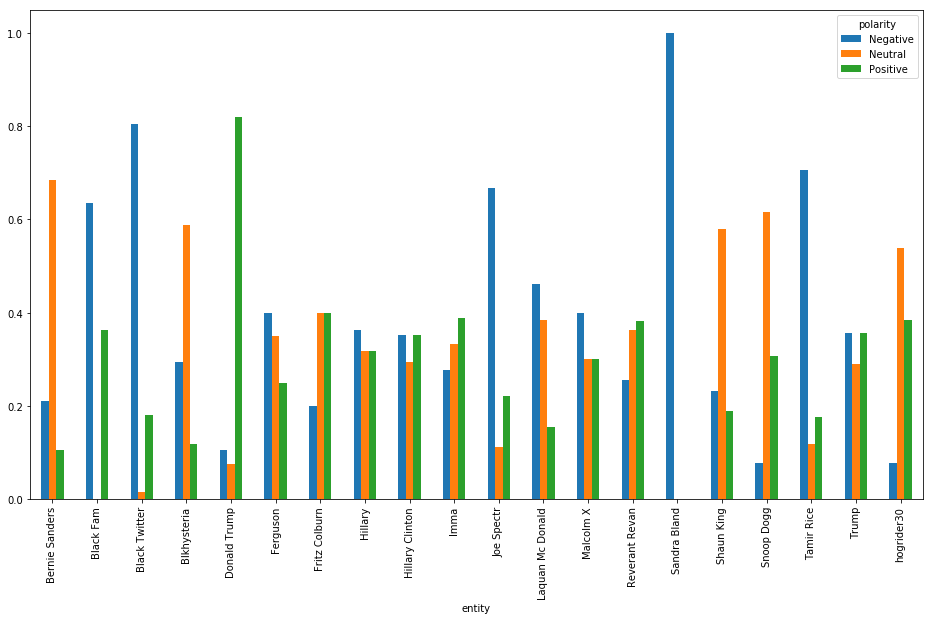

In [163]:
top20people_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20people))])
top20people_polarity = (top20people_polarity.entities.apply(pd.Series)
                        .merge(top20people_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20people_polarity = (top20people_polarity.loc[top20people_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20people))])
top20people_polarity = top20people_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
top20people_polarity.plot(kind = 'bar', figsize=(16,9))
#top20people_polarity

In [150]:
top20people_polarity.head()

,polarity,entity
0,Positive,Dan Bongino
1,Positive,Hillary
2,Positive,Donald Trump
3,Positive,Donald Trump
4,Neutral,Russians
